In [359]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import joblib
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [360]:
# Importing data
df = pd.read_csv("anomaly_removed.csv")
df.head(2)

,Timestamp,OxEnRa,BlFuPeIn,EnOxFl,CoBlFl,BlMo,BlFuBoGaVo,BlFuBoGaIn,ThCoTe,ToGaPr,...,CoBlTe,HoBlTe,ToTe,BlHu,CoInSeVa,FoSI,HoBl,ToGasP,CoBF,SI
0,2021-05-12 17:56:25.000,3.691772,17.661523,16941.904350,36.472670,146.285825,7925.957227,81.975757,2210.712256,224.366480,...,212.936183,1087.730999,1.79588,13.118669,45.994059,0.481272,1075.254532,221.600735,36.796521,0.479000
1,2021-05-12 17:56:25.000,3.744628,0.193811,17554.954071,34.087434,161.762571,8049.518860,81.637472,2268.780322,0.005692,...,213.288686,2.082851,1.79588,10.353929,1.580861,0.337968,2.110829,0.005584,34.238289,0.312456


In [361]:
df.shape

(5366, 25)

#### Model training

In [334]:
X, y = df.iloc[:,1:-1].values, df.iloc[:,-1].values

# Creating train+calibration and test set
X_train_and_cal, X_test, y_train_and_cal, y_test = train_test_split(X, y, test_size=0.3, 
                                                                    shuffle=False, random_state=42)
# Creating train and calibration set
X_train, X_cal, y_train, y_cal = train_test_split(X_train_and_cal, y_train_and_cal, test_size=0.2,
                                                   shuffle=False, random_state=42)

print(X_train.shape)

model = XGBRegressor(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    gamma=0.3,
    objective='reg:squarederror',
    random_state=42
)

model.fit(X_train, y_train)

(3004, 23)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.3, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=150,
             n_jobs=None, num_parallel_tree=None, ...)

In [335]:
joblib.dump(model, 'xgbr_si_model.pkl')

['xgbr_si_model.pkl']

In [336]:
# Calculate model performance
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

R² Score: 0.3969
RMSE: 0.0862
MAPE: 14.84%


In [337]:
print(y_test.min(), y_test.max(), y.mean())

0.174 0.916 0.4639773282961524


In [368]:
0.0862/0.4639

0.1858159086009916

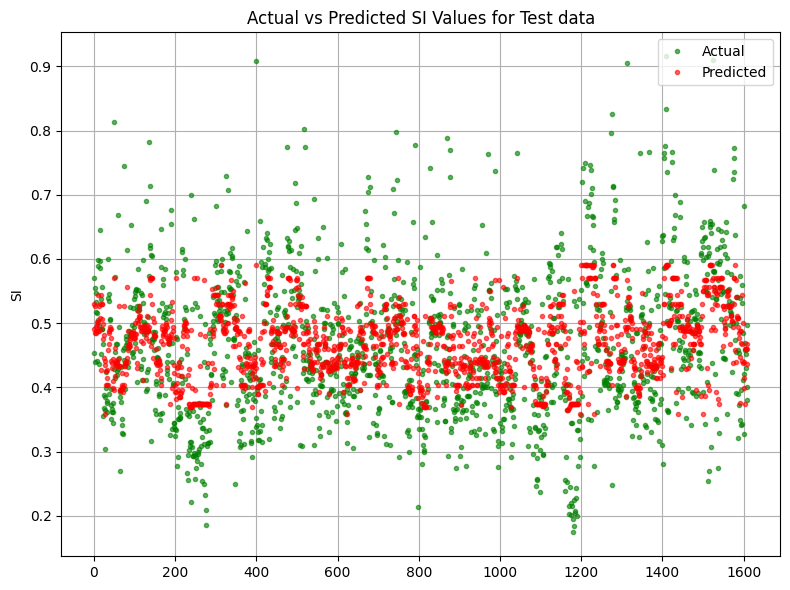

In [371]:
# Plot actual vs predicted
y_pred = model.predict(X_test)

plt.figure(figsize=(8, 6))
plt.plot(y_test, alpha=0.6, color='green', linestyle='', marker='o', markersize=3, label='Actual')
plt.plot(y_pred, alpha=0.6, color='red', linestyle='', marker='o', markersize=3,  label='Predicted')
plt.grid(True)
plt.legend(loc='upper right')
plt.ylabel("SI")
plt.title("Actual vs Predicted SI Values for Test data")
plt.tight_layout()
plt.show()

#### Confidence interval prediction

In [372]:
from mapie.regression import MapieRegressor

In [373]:
# Using fitted model to calculate confidence intervals
mapie = MapieRegressor(estimator=model, cv="prefit"
  ).fit(X_cal, y_cal)

y_test_pred_interval = mapie.predict(X_test, alpha=.05)

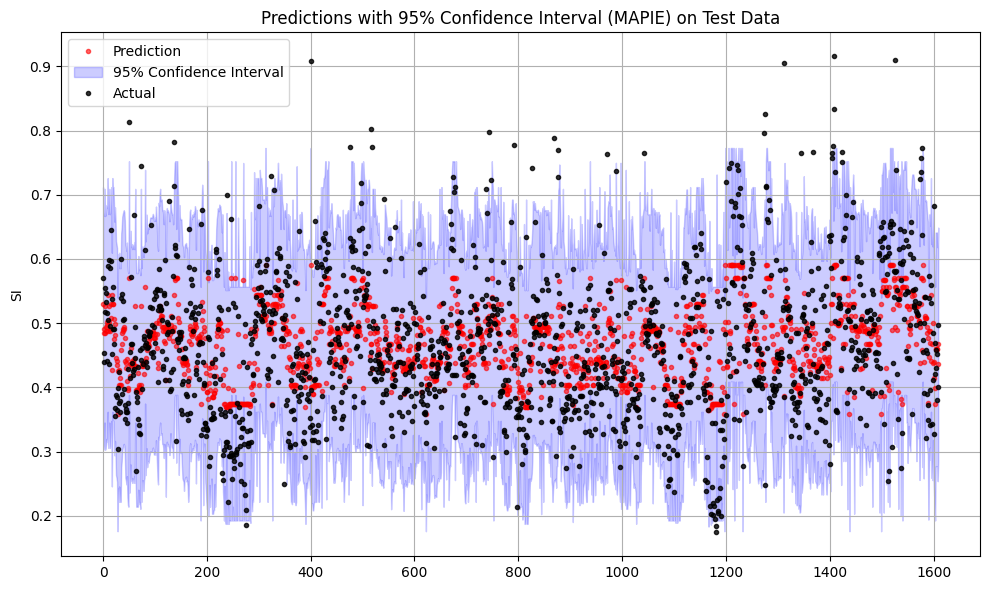

In [374]:
# Plotting confidence interval
y_pred, y_pis = mapie.predict(X_test, alpha=0.05)

plt.figure(figsize=(10, 6))

plt.plot(y_pred, label='Prediction', color='red', linestyle='', marker='o', markersize=3, alpha=0.6)

plt.fill_between(
    x=range(len(y_pred)),
    y1=y_pis[:, 0, 0],
    y2=y_pis[:, 1, 0],  
    alpha=0.2,
    color='blue',
    label='95% Confidence Interval'
)

plt.plot(y_test, label='Actual', color='black', linestyle='', marker='o', markersize=3, alpha=0.8)

plt.ylabel("SI")
plt.title("Predictions with 95% Confidence Interval (MAPIE) on Test Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Feature importance

In [342]:
import shap

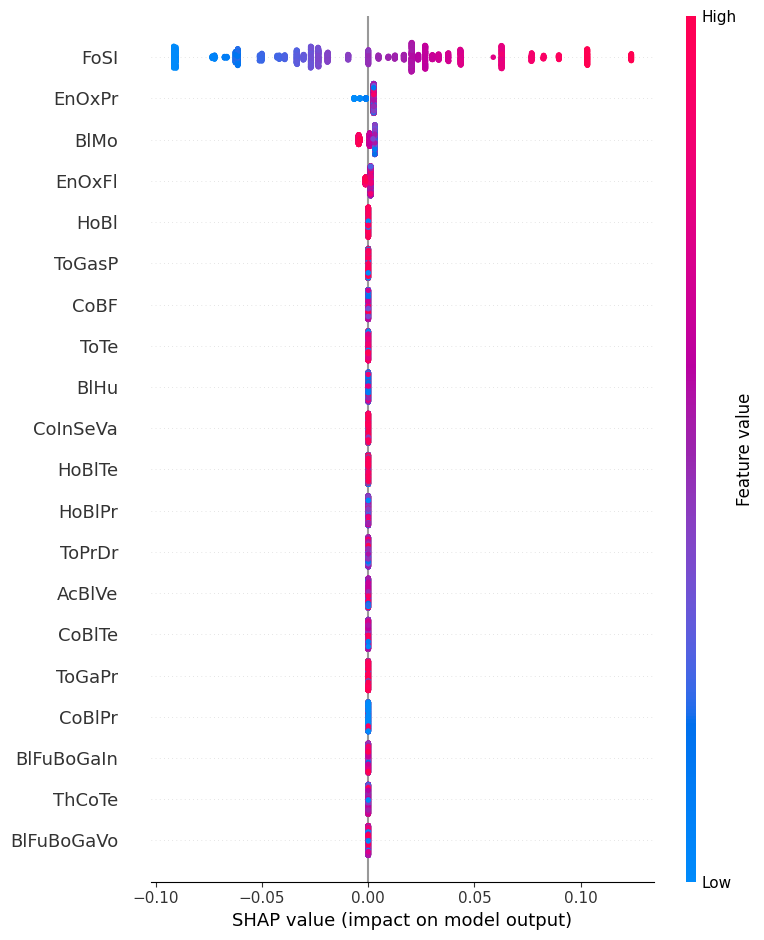

In [ ]:
# SHAP value calculation
X_train_shap = pd.DataFrame(X_train, columns=df.iloc[:,1:-1].columns)
X_test_shap = pd.DataFrame(X_test, columns=df.iloc[:,1:-1].columns) 

explainer = shap.Explainer(model, X_train_shap)

shap_values = explainer(X_test_shap)

shap.summary_plot(shap_values, X_test_shap)

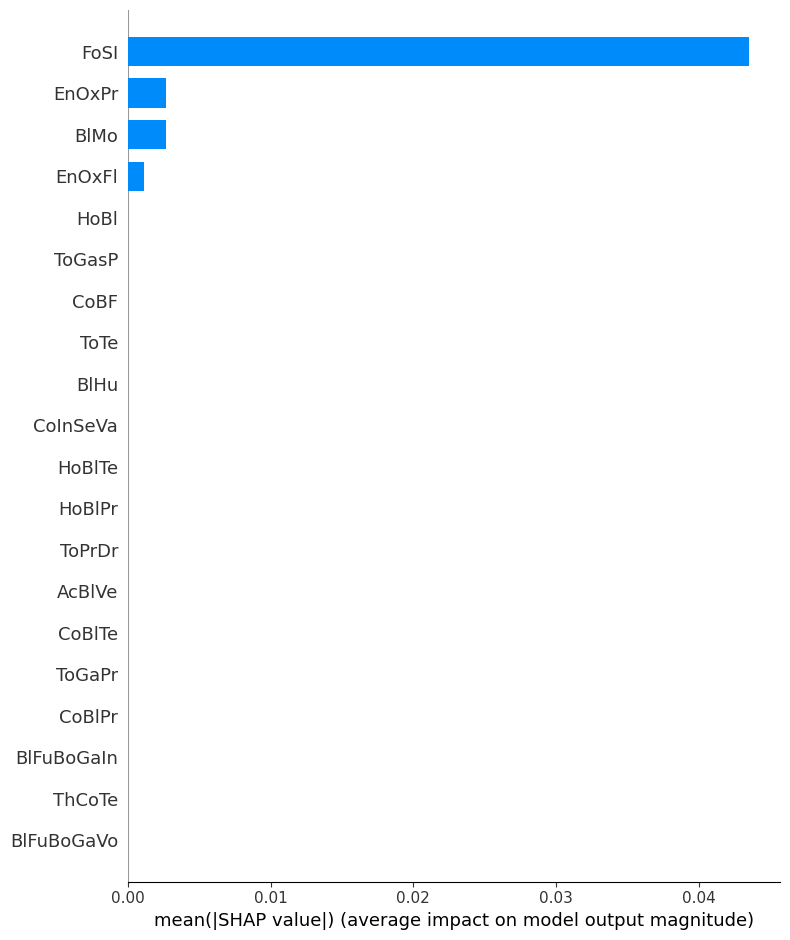

In [344]:
shap.summary_plot(shap_values, X_test_shap, plot_type="bar")

#### Fitting model based on SHAP values

In [346]:
X, y = df.loc[:,['FoSI', 'EnOxPr', 'BlMo', 'EnOxFl']].values, df.iloc[:,-1].values

# Creating train+calibration and test set
X_train_and_cal, X_test, y_train_and_cal, y_test = train_test_split(X, y, test_size=0.3, 
                                                                    shuffle=False, random_state=42)
# Creating train and calibration set
X_train, X_cal, y_train, y_cal = train_test_split(X_train_and_cal, y_train_and_cal, test_size=0.2,
                                                   shuffle=False, random_state=42)

print(X_train.shape)

model = XGBRegressor(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    gamma=0.3,
    objective='reg:squarederror',
    random_state=42
)

model.fit(X_train, y_train)

(3004, 4)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.3, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=150,
             n_jobs=None, num_parallel_tree=None, ...)

In [347]:
# Calculate model performance
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

R² Score: 0.3969
RMSE: 0.0862
MAPE: 14.84%


In [348]:
print(y_test.min(), y_test.max(), y.mean())

0.174 0.916 0.4639773282961524
